In [1]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [3]:
train_path = 'car-damage-dataset/data1a/training'
test_path = 'car-damage-dataset/data1a/validation'

In [4]:
image_files = glob(train_path + '/*/*.jp*g')
test_files = glob(test_path + '/*/*.jp*g')

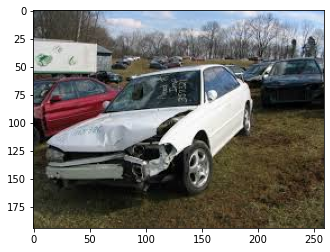

In [5]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## Baseline VGG19 pretrained model

In [6]:
vgg = VGG19(include_top=False,input_shape=[224,224,3])

In [7]:
for layer in vgg.layers:
    layer.trainable = False

In [8]:
x = Flatten()(vgg.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(2,activation='softmax')(x)

In [9]:
model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model.compile('adam','binary_crossentropy',metrics=['accuracy'])


In [6]:
gen = ImageDataGenerator(rescale=1./255)

In [7]:
test_gen = gen.flow_from_directory(test_path, target_size=(224,224))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 460 images belonging to 2 classes.
{'00-damage': 0, '01-whole': 1}


min: 0.0 max 1.0


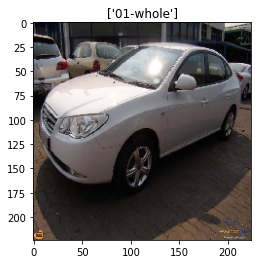

In [8]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [9]:
train_gen = gen.flow_from_directory(train_path, target_size=(224,224))

Found 1840 images belonging to 2 classes.


In [10]:
batch_size = 128

r = model.fit_generator(train_gen,validation_data=test_gen,
                        epochs=20, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size)

NameError: name 'model' is not defined

In [17]:
model.evaluate(test_gen)

15/15 [==============================] - 3s 208ms/step - loss: 0.2344 - accuracy: 0.9087


[0.23436826467514038, 0.908695638179779]

In [18]:
model.evaluate(train_gen)

58/58 [==============================] - 8s 136ms/step - loss: 0.0742 - accuracy: 0.9815


[0.07419028878211975, 0.981521725654602]

In [19]:
def get_confusion_matrix(data_path, N, model):
    print('generating confusion_matrix')
    predictions = []
    targets = []
    for x,y in gen.flow_from_directory(data_path, target_size=(224,224),shuffle=False):
        p = model.predict(x)
        p = np.argmax(p, axis = 1)
        y = np.argmax(y, axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets, y))
        if len(targets)>=N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

In [20]:
cm = get_confusion_matrix(train_path, len(image_files), model)
print(cm)

generating confusion_matrix
Found 1840 images belonging to 2 classes.
[[905  15]
 [ 19 901]]


In [21]:
valid_cm = get_confusion_matrix(test_path, len(test_files), model)
print(valid_cm)

generating confusion_matrix
Found 460 images belonging to 2 classes.
[[214  16]
 [ 26 204]]


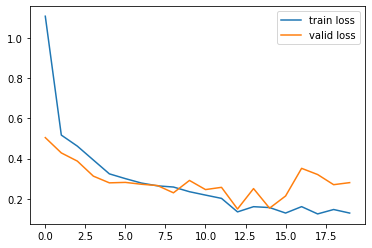

In [22]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

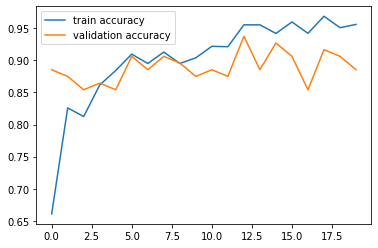

In [23]:
plt.plot(r.history['accuracy'], label = 'train accuracy')
plt.plot(r.history['val_accuracy'], label ='validation accuracy')
plt.legend()
plt.show()

## ResNeXt pretrained model

In [53]:
from classification_models.tfkeras import Classifiers

ResNeXt50, preprocess_input = Classifiers.get('resnext50')
resnext = ResNeXt50(include_top = False, input_shape=(256, 256, 3), weights='imagenet')

In [27]:
# Classifiers.models_names()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


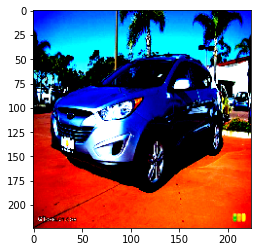

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

layer = Normalization(mean=[0.485, 0.456, 0.406], 
                      variance=[np.square(0.299), 
                                np.square(0.224), 
                                np.square(0.225)])


input_data = np.array(test_gen[0][0][2])

test_gen[0][0][2] = layer(input_data).numpy()

plt.imshow(layer(input_data).numpy())



In [51]:
(train_gen[0][1]).shape

(32, 2)

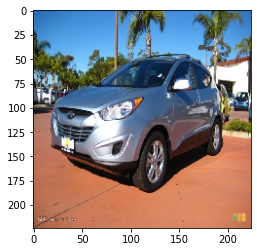

In [19]:
plt.imshow(test_gen[0][0][2])

In [54]:
for layer in resnext.layers:
    layer.trainable = False

In [55]:
x = Flatten()(resnext.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(2,activation='softmax')(x)

In [56]:
model_resnext = Model(inputs=resnext.input, outputs=prediction)

In [57]:
from tensorflow.keras.optimizers import RMSprop

model_resnext.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy'],
    )

C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [58]:
gen = ImageDataGenerator(rescale=1./255)

In [59]:
test_gen = gen.flow_from_directory(test_path, target_size=(256,256))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 460 images belonging to 2 classes.
{'00-damage': 0, '01-whole': 1}


min: 0.0 max 1.0


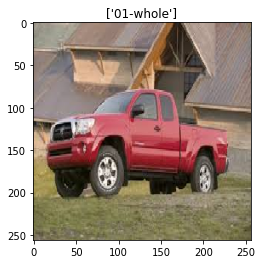

In [60]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [61]:
train_gen = gen.flow_from_directory(train_path, target_size=(256,256))

Found 1840 images belonging to 2 classes.


In [62]:
batch_size = 32

r_resnext = model_resnext.fit(train_gen,validation_data=test_gen,
                        epochs=10, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size)

Epoch 1/10
57/57 [==============================] - 29s 299ms/step - loss: 0.8330 - accuracy: 0.5437 - val_loss: 0.6534 - val_accuracy: 0.6406
Epoch 2/10
57/57 [==============================] - 13s 228ms/step - loss: 0.6719 - accuracy: 0.5902 - val_loss: 0.6469 - val_accuracy: 0.6295
Epoch 3/10
57/57 [==============================] - 13s 232ms/step - loss: 0.6520 - accuracy: 0.6012 - val_loss: 0.6577 - val_accuracy: 0.5647
Epoch 4/10
57/57 [==============================] - 13s 228ms/step - loss: 0.6438 - accuracy: 0.6117 - val_loss: 0.6221 - val_accuracy: 0.6496
Epoch 5/10
57/57 [==============================] - 13s 228ms/step - loss: 0.6178 - accuracy: 0.6438 - val_loss: 0.6097 - val_accuracy: 0.6629
Epoch 6/10
57/57 [==============================] - 13s 227ms/step - loss: 0.6152 - accuracy: 0.6377 - val_loss: 0.6127 - val_accuracy: 0.6786
Epoch 7/10
57/57 [==============================] - 13s 228ms/step - loss: 0.6141 - accuracy: 0.6471 - val_loss: 0.5974 - val_accuracy: 0.7188

In [63]:
model_resnext.evaluate(train_gen)

58/58 [==============================] - 9s 160ms/step - loss: 0.5543 - accuracy: 0.7473


[0.5543115139007568, 0.7472826242446899]

In [64]:
model_resnext.evaluate(test_gen)

15/15 [==============================] - 3s 192ms/step - loss: 0.5676 - accuracy: 0.7261


[0.5676288604736328, 0.7260869741439819]

In [65]:
cm = get_confusion_matrix(train_path, len(image_files), model_resnext)
print(cm)

NameError: name 'get_confusion_matrix' is not defined

In [ ]:
valid_cm = get_confusion_matrix(test_path, len(test_files), model_resnext)
print(valid_cm)

generating confusion_matrix
Found 460 images belonging to 2 classes.
[[230   0]
 [230   0]]


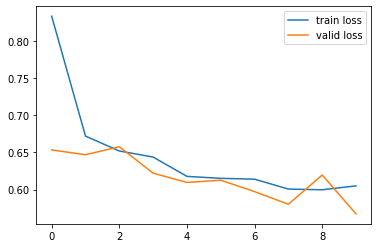

In [66]:
plt.plot(r_resnext.history['loss'],label = 'train loss')
plt.plot(r_resnext.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

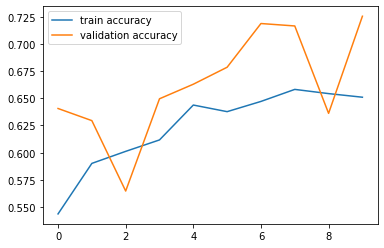

In [67]:
plt.plot(r_resnext.history['accuracy'], label = 'train accuracy')
plt.plot(r_resnext.history['val_accuracy'], label ='validation accuracy')
plt.legend()
plt.show()

## Efficient Net V2 implementation

In [57]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

eff_net_v2s = EfficientNetV2S()


In [58]:
for layer in eff_net_v2s.layers:
    layer.trainable = False

In [59]:
x = Flatten()(eff_net_v2s.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(2,activation='softmax')(x)

In [60]:
model_eff_net_v2s = Model(inputs=eff_net_v2s.input, outputs=prediction)

In [61]:
model_eff_net_v2s.compile('RMSprop','binary_crossentropy',metrics=['accuracy'])

In [62]:
gen = ImageDataGenerator(rescale=1./255)

In [63]:
test_gen = gen.flow_from_directory(test_path, target_size=(224,224))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 460 images belonging to 2 classes.
{'00-damage': 0, '01-whole': 1}


min: 0.0 max 1.0


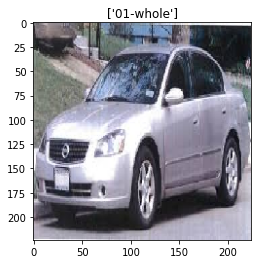

In [64]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [65]:
train_gen = gen.flow_from_directory(train_path, target_size=(224,224))

Found 1840 images belonging to 2 classes.


In [67]:


r_eff_net_v2s = model_eff_net_v2s.fit(train_gen,validation_data=test_gen,
                        epochs=10, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size)

Epoch 1/10
14/14 [==============================] - 2s 124ms/step - loss: 0.6931 - accuracy: 0.5134 - val_loss: 0.6938 - val_accuracy: 0.4583
Epoch 2/10
14/14 [==============================] - 2s 117ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 3/10
14/14 [==============================] - 2s 126ms/step - loss: 0.6934 - accuracy: 0.4888 - val_loss: 0.6931 - val_accuracy: 0.4896
Epoch 4/10
14/14 [==============================] - 2s 130ms/step - loss: 0.6931 - accuracy: 0.4978 - val_loss: 0.6927 - val_accuracy: 0.5729
Epoch 5/10
14/14 [==============================] - 2s 127ms/step - loss: 0.6930 - accuracy: 0.5134 - val_loss: 0.6937 - val_accuracy: 0.4688
Epoch 6/10
14/14 [==============================] - 2s 112ms/step - loss: 0.6916 - accuracy: 0.5486 - val_loss: 0.6936 - val_accuracy: 0.4896
Epoch 7/10
14/14 [==============================] - 2s 118ms/step - loss: 0.6919 - accuracy: 0.5290 - val_loss: 0.6929 - val_accuracy: 0.5104
Epoch 

In [ ]:
model_eff_net_v2s.evaluate(train_gen)

58/58 [==============================] - 5s 90ms/step - loss: 0.6922 - accuracy: 0.5386


[0.6922311782836914, 0.5385869741439819]

In [53]:
model_eff_net_v2s.evaluate(test_gen)

15/15 [==============================] - 2s 110ms/step - loss: 0.6924 - accuracy: 0.5130


[0.6924028396606445, 0.5130434632301331]

In [54]:
cm = get_confusion_matrix(train_path, len(image_files), model_eff_net_v2s)
print(cm)

generating confusion_matrix
Found 1840 images belonging to 2 classes.


ValueError: in user code:

    File "C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Firas\AppData\Local\pypoetry\Cache\virtualenvs\comp6604-project-fKVoAw_g-py3.9\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 384, 384, 3), found shape=(32, 224, 224, 3)


In [ ]:
valid_cm = get_confusion_matrix(test_path, len(test_files), model_eff_net_v2s)
print(valid_cm)

generating confusion_matrix
Found 460 images belonging to 2 classes.
[[230   0]
 [230   0]]


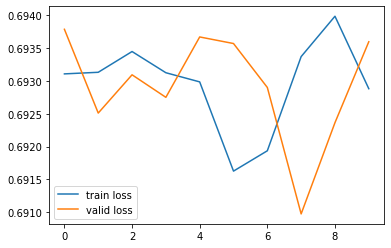

In [68]:
plt.plot(r_eff_net_v2s.history['loss'],label = 'train loss')
plt.plot(r_eff_net_v2s.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

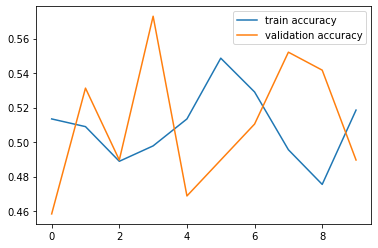

In [69]:
plt.plot(r_eff_net_v2s.history['accuracy'], label = 'train accuracy')
plt.plot(r_eff_net_v2s.history['val_accuracy'], label ='validation accuracy')
plt.legend()
plt.show()